In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import zeta #https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.zeta.html
plt.style.use('classic')

<br>
<font size = 15>Fitting Zipf's law (discrete):</font>
<br><br>
The discrete Zipf's distribution is : <br>
\begin{equation}P_k=Ck^{-\alpha}\end{equation}
The normalized condition gives:<br>
\begin{equation}1=\sum P_k=C\sum_{m}^{n}(\frac{1}{k^\alpha}) = C(\zeta(\alpha, m) - \zeta(\alpha, n+1))\Rightarrow C=1/H(m,n,\alpha)\end{equation}
Where $H(m,n,\alpha)\equiv \sum_{m}^{n}\frac{1}{k^\alpha}=\zeta(\alpha, m) - \zeta(\alpha, n+1)$, $\zeta(\alpha, m)$ is Hurwitz zeta function.<br>

Now give a raw data $X=[x_1,x_2,x_3...,x_N]$ where $x_i$ is the word of utterance, the likelihood is:<br>
\begin{equation}L=\prod_{i=1}^{N}P(x_i|\alpha)=\prod_{i=1}^{k}P(y_i|\alpha)^{\rho(y_i)}=\prod_{i=1}^{k}\big[\frac{y_i^{-\alpha}}{H(y_1,y_k,\alpha)}\big]^{\rho(y_i)}\end{equation}
where $Y=[y_1, y_2...,y_k]$ is a rank set of non-repeat $X$ with frequency $\rho(y_i)$


The maximum likelihood estimation (MLE) requires $L$ be maximum, and then $\ln(L)$ will also be max:<br>
\begin{equation}0=\frac{\partial\ln{L}}{\partial \alpha}=-\sum_{i=1}^{k}{\rho(y_i)\ln{y_i}}+\frac{N}{H(y_1,y_k,\alpha)}\sum_{i=1}^{k}\frac{\ln{(y_i)}}{y_i^{ \alpha}}\end{equation}

However we can't solve $\alpha$ exactly in this form. Instead, we use the minimize function in scipy:
\begin{equation}max(\ln L(\alpha))=min(-1*\ln L(\alpha))\end{equation}
\begin{equation}\Rightarrow \alpha = \alpha_1, C=1/H(y_1,y_k,\alpha_1)\end{equation}


Ps. This result is better than Eq.(38) in ref 1, where use $\zeta (y_1, \alpha)$ instead of $H(y_1,y_k,\alpha_1)$

<ref>Reference: <br>
1. https://arxiv.org/pdf/cond-mat/0412004.pdf Appendix.B
2. scipy.minimize: https://www.youtube.com/watch?v=cXHvC_FGx24
3. scipy minimize function with parameters: https://stackoverflow.com/questions/43017792/minimize-function-with-parameters


In [2]:
def incomplete_harmonic(x):
    x_min = x[0]
    x_max = x[1]
    s = x[2]
    P = 0
    for k in range(int(x_min) , int(x_max) + 1):
        P = P + 1 / (k)**s
    return P

def Zipf_law(x, s, C):
    return C*x**(-s)

In [3]:
def Two_to_One(y):
    #y = ([rank], [frequency of the rank])
    Y = []
    for i in y[0]:
        Y.append(i)
    for i in y[1]:
        Y.append(i)
    return Y

def One_to_Two(Y):
    y = [[], []]
    length = len(Y) * 0.5
    for i in range(int(length)):
        y[0].append(Y[i])
    for i in range(int(length)):
        y[1].append(Y[i + int(length)])
    return y


def L_Zipf(s, Y):
    y = One_to_Two(Y)
    #y = ([rank], [frequency of the rank])
    ln = 0
    for i in range(len(y[1])):
        ln = ln + y[1][i] * np.log(y[0][i])
    N = sum(y[1])
    x = (int(min(y[0])), int(max(y[0])), s) #y[2] is exponent
    return s * ln + N * np.log(incomplete_harmonic(x))

def L_Zipf_zeta(s, Y):
    y = One_to_Two(Y)
    #y = ([rank], [frequency of the rank])
    ln = 0
    for i in range(len(y[1])):
        ln = ln + y[1][i] * np.log(y[0][i])
    N = sum(y[1])
    return s * ln + N * np.log(zeta(s, int(min(y[0]))))

<br>
<font size = 15>What is goodness of fitting in MLE ?</font>
<br><br>
If we KNOW the distribution of experiment data (the error distribution) is normal distribution, the likelihood of getting the best fitting function can be written down as :
\begin{equation}L=\prod_{i=1}^{k}\frac{1}{\sqrt{2\pi}\sigma_i}e^{-(y_i - g(x_i))^2/(2\sigma_i^2)}\end{equation}


This likelihood is used to maximize the probability of finding the theortical vaule (fitting model $g(x_i)$) close to experiment value ($y_i$). When we apply this $L$ with MLE, we get the condition the $L=max(L)$ is :
\begin{equation}\chi^2 =\sum_{i=1}^{k}(y_i - g(x_i))^2/(2\sigma_i^2)\end{equation}
should be minimized.<br>

This will lead to the result in OLS(ordinary least square). However we don't know the distribution of our data, even the error bars. So we must fixed this standard of good of fitting here. The generalized case of fitting should use the likelihood we mentioned before:
\begin{equation}L=\prod_{i=1}^{N}g(x_i|\alpha)=\prod_{i=1}^{k}g(y_i|\alpha)^{\rho(y_i)}\end{equation}

......(to be continue)


<ref>Reference: <br>
1. https://arxiv.org/pdf/1505.02016.pdf Appendix.C
2. http://www3.stat.sinica.edu.tw/statistica/oldpdf/a16n39.pdf
3. https://arxiv.org/vc/cond-mat/papers/0402/0402322v1.pdf
4. https://arxiv.org/pdf/cond-mat/0402322.pdf
5. https://cran.r-project.org/web/packages/zipfR/zipfR.pdf


the best value of exponent is 2.770936, C is 0.814879


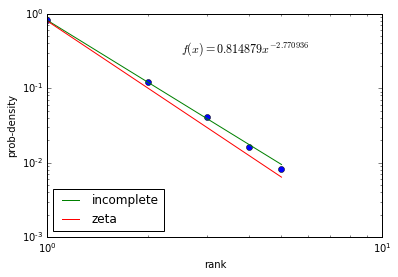

In [4]:
def main():
    y = ([1,2,3,4,5], [100,15,5,2,1])
    a = y
    Y = Two_to_One(a)
    res = minimize(L_Zipf, 1.2, Y, method = 'SLSQP')
    s = res['x']
    t = (int(min(y[0])), int(max(y[0])), s)
    C = 1 / incomplete_harmonic(t)
    print('the best value of exponent is %f, C is %f' % (s, C))
    
    #compare incomplete harmonic and zeta function to see their difference
    res_zeta = minimize(L_Zipf_zeta, 1.2, Y, method = 'SLSQP')
    s_zeta = res_zeta['x']
    C_zeta = 1 / zeta(s, int(min(y[0])))
    
    N = sum(y[1])
    p = [i / N for i in y[1]]
    plt.plot(y[0], p, 'o')
    xdata = np.linspace(min(y[0]), max(y[0]), num = (max(y[0]) - min(y[0]))*10)
    theo = Zipf_law(xdata, s, C)
    theo_zeta = Zipf_law(xdata, s_zeta, C_zeta)
    
    plt.text(2.5, 0.3,'$f(x)=%fx^{-%f}$'%(C, s), fontsize=12)
    plt.plot(xdata, theo, 'g-', label = 'incomplete')
    plt.plot(xdata, theo_zeta, 'r-', label = 'zeta')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('prob-density')
    plt.xlabel('rank')
    plt.legend(loc = 'lower left')
    plt.show()
    
if __name__ == '__main__':
    main()